#### Thanks to the tutorial i found __[here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)__, I was able to build this out fairly quickly and get a pretty general understanding in spaCy and Gensim
<br>
Import base packages and previously cleaned data
<br>
Also recall that there's some input language issues we are facing and we want to only use English comments, hence we only used English words match via NTLK stopwords

Loading basic package and dataset:

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
%store -r df_clean

In [2]:
# a lot of comments dont have stop words so it's a littile bit harder than expected to id language
df_clean = df_clean.loc[(df_clean.pro_lan == 'english' )& (df_clean.con_lan == 'english'),:]

df_clean.head()

,date,reviewNo,type,position,summary,pro,con,advice,overallStar,record,pro_lan,con_lan
0,"Jun 29, 2018",empReview_21272752,Former Employee,Anonymous Employee,Great Place to Work!,Great technology and great people,Some district managers could use more time in ...,Follow up more,5.0,1,english,english
1,"Aug 28, 2014",empReview_4870579,Current Employee,Anonymous Employee,"Challenging, Rewarding, but ZERO work/life bal...","We work with geniuses - in every department, W...",ZERO ZERO ZERO work/life balance. Execs have b...,None,4.0,1,english,english
2,"Mar 10, 2017",empReview_14128330,Current Employee,Specialist,A Company as Meticulous as Their Products!,"Competitive Pay, Great Benefits, Amazing Peopl...",None! I had one of the best times ever at this...,You guys are awesome. Keep up the good work!,5.0,1,english,english
3,"May 13, 2015",empReview_6585844,Current Employee,Apple At Home Advisor,At-Home-Advisor,The position is at home. The company is AMAZIN...,The schedule changes every 90 days and you hav...,The management consists of a team manager and ...,5.0,1,english,english
4,"Jan 22, 2016",empReview_9295224,Current Employee,Software Engineer IV,Changing the world (in a small way),Working at Apple means that the things you wor...,"It's a lot of work, teams are usually strapped...","Keep fighting for ""what's right"". Renewable en...",5.0,1,english,english


We'll be using primarily spaCy and Gensim for Topic Modeling as NLTK has been proved good for research but not for fast and scalable solution <br>

In [3]:
import spacy
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_sm') #load spaCy english preprocessing pipline
stopwords = set(stopwords.words('english')) # load stopwords from NLTK
# adding stopwords if needed => stopwords added as a result of topic modeling
stopwords.add('apple')
stopwords.add('be')
stopwords.add('retail')
stopwords.add('work')
# adding stopwords to spaCy pipeline
for word in stopwords:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

doc = nlp(df_clean.pro[0].lower())

#### Some great things about spaCy:
- Dependency Parsing
- Entity Detection

In [4]:
# dependency parsing
from spacy import displacy
displacy.render(doc, style='dep', minify = True,jupyter=True)

In [5]:
# entity detection
displacy.render(nlp(df_clean.pro[4]), style = 'ent', jupyter = True)

*Note that if you convert all the text into lower case, 'Apple' won't be detected as an ORG*

#### Text Preprocessing

---
Still there are some preprocessing steps we need to do
- Lemmatization
- Creating Bi/Tri Grams for Topic Modeling

In [6]:
# lemmatization
test_doc = [''.join(w.lemma_) for w in doc if not w.is_stop and not w.is_punct]
print(test_doc)

['great', 'technology', 'great', 'people']


In [7]:
# now writing a function to pre-processing any given df.col
def spacy_preprocess(dfcol):
    '''input df.col and return a list of lists of preprocessed texts using spaCy'''
    col_comment = []
    for comment in dfcol:
        if type(comment) is str:
            preprocess = nlp(comment.lower())
        text = [(w.lemma_) for w in preprocess if not w.is_stop and not w.is_punct and not w.like_num] # also remove numbers
        col_comment.append(text)
    return col_comment #output a list of lists


In [8]:
summary_list, pro_list, con_list = spacy_preprocess(
    df_clean.summary), spacy_preprocess(df_clean.pro),spacy_preprocess(df_clean.con)
print(pro_list[0])

['great', 'technology', 'great', 'people']


Now using the processed corpus to generate bi/tri grams depending on word frequency, using Gensim

In [9]:
import gensim
import warnings
warnings.filterwarnings(action='ignore') #ignore user warnings

bigram = gensim.models.Phrases(pro_list, min_count = 10, threshold = 100) #using higer threshold for fewer phrases
bigram_mod = gensim.models.phrases.Phraser(bigram)

print(bigram_mod[bigram_mod[pro_list[3]]])

['position', 'home', 'company', 'amazing', 'limitless', 'advancement', 'opportunity', 'cool', 'people', 'leadership', 'care', 'development', 'coach', 'batter', 'belittle', 'pay', 'decent', 'benefit', 'include', '401(k', 'match', 'stock', 'purchase', 'option', 'product', 'discount', 'discount', 'service', 'different', 'area', 'education', 'assistance', 'child', 'care', 'assistance', 'pay', 'vacation_sick', 'time', 'time', 'option', 'health', 'club', 'reimbursment', 'bike', 'cost', 'set', 'time', 'ot', 'be', 'pretty', 'unlimited', 'long', 'not', 'exceed', 'hour', 'day', 'total', 'week']


We separate preprocessing & bi-gram for now as topic modeling might suggest better outputs using trigram or we might need to modify preprocessing a little bit to take out some extra words/adding new stop words 

In [10]:
# writing above codes to functions for summary, pro & con bi gram separately
def bigram(text):
    bigram = gensim.models.Phrases(text, min_count = 10, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    return [bigram_mod[doc] for doc in text]

summary_list, pro_list, con_list = bigram(summary_list), bigram(pro_list),bigram(con_list)


Since Summary has relatively short text, we'll try Pros and Cons for now
<br>
> Creating a dictionary & text corpus for Pros & Cons; <br>
> Rewrite them into functions so that we can call it multiple times

In [11]:
import gensim.corpora as corpora

# create dictionary (id2word)
pro_dict = corpora.Dictionary(pro_list)
# create mapping frequency(Corpus)
pro_mapping = [pro_dict.doc2bow(text) for text in pro_list]

# see mapping for dictionary
print(pro_mapping[:1])

# take a look at a more readable format
print([[(pro_dict[key], freq) for key, freq in corpus] for corpus in pro_mapping[:1]])

[[(0, 2), (1, 1), (2, 1)]]
[[('great', 2), ('people', 1), ('technology', 1)]]


In [12]:
# now format above into function since we need pro & con
def mapping(text):
    '''using input text to create a fequency dictionary'''
    id2word = corpora.Dictionary(text) #id2word
    corpus = [id2word.doc2bow(text) for text in text] #corpus   
    return id2word, corpus

con_id2word, con_corpus = mapping(con_list)

#### Building the LDA Model

Steps:
1. Preprocessing text into Corpus <br>
    (*Use mapping function written above*)
    1. Using Gensim Corpora to create a dictionary
    2. Using mapping word frequency to corpus
2. Generate LDA model using Gensim
3. Compute model perplexity and coherence score
4. Visualize model using pyLDAvis (optional)

In [13]:
lda_pro = gensim.models.ldamodel.LdaModel(corpus = pro_mapping, 
                                          num_topics = 10,
                                          random_state = 12345,
                                          id2word = pro_dict, 
                                          alpha = 'auto')

pprint(lda_pro.print_topics())


[(0,
  '0.039*"product" + 0.027*"great" + 0.022*"good" + 0.020*"people" + '
  '0.019*"technology" + 0.018*"close" + 0.018*"exciting" + 0.015*"edge" + '
  '0.015*"passion" + 0.014*"present"'),
 (1,
  '0.112*"good" + 0.043*"nice" + 0.034*"environment" + 0.033*"salary" + '
  '0.028*"computer" + 0.027*"great" + 0.025*"discount" + 0.021*"company" + '
  '0.019*"compare" + 0.018*"music"'),
 (2,
  '0.061*"company" + 0.054*"work" + 0.028*"life" + 0.020*"good" + '
  '0.016*"customer" + 0.015*"not" + 0.015*"experience" + 0.014*"innovative" + '
  '0.014*"\'s" + 0.014*"individual"'),
 (3,
  '0.098*"great" + 0.034*"benefit" + 0.032*"discount" + 0.030*"company" + '
  '0.023*"employee" + 0.019*"profile" + 0.019*"product" + 0.016*"stock" + '
  '0.015*"management" + 0.014*"people"'),
 (4,
  '0.026*"push" + 0.026*"easy" + 0.024*"people" + 0.021*"fire" + '
  '0.021*"product" + 0.021*"chance" + 0.020*"current" + 0.020*"good" + '
  '0.019*"free" + 0.017*"software"'),
 (5,
  '0.038*"management" + 0.035*"stev

Computing Model Perplexity and Coherence Score

In [14]:
from gensim.models import CoherenceModel

print('\nPerplexity:', lda_pro.log_perplexity(pro_mapping)) # the lower the better

coherence_model_pro = CoherenceModel(model = lda_pro, 
                                     texts = pro_list, 
                                     dictionary = pro_dict, 
                                     coherence = 'c_v')
coherence_lda_pro = coherence_model_pro.get_coherence()

print('\nCoherence Score:', coherence_lda_pro)


Perplexity: -7.45862123648

Coherence Score: 0.36294926267


Now Visualize the topics (taking out for now)

In [15]:
# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this

# import warnings
# warnings.filterwarnings(action='ignore', category=FutureWarning)

# pyLDAvis.enable_notebook()
# vis_pro = pyLDAvis.gensim.prepare(lda_pro, pro_mapping, pro_dict) 
# pyLDAvis.display(vis_pro)

#### Now that we got a working model, here are a few things we still need to do:
1. Apply the same process to get df_clean.con results
2. Find the optimal number of topic per text corpus
3. Find dominant topic per review (pro & con)   *--to be added later*
4. Find most representative document for each topic   *--to be added later*

---
Also, with both Pro & Con Topic Modeling, we can see that there are some works that doesn't really add meanings to the topic, we want to try to add those to our customized stopwords dictionary and subsequently remove those. <br>
Words appeared in topic modeling that be added to stopwords:
- be
- apple
- retail
- work

*(Going back to Input 3 & adding stopwords)*

In [16]:
def ldamod(source_list, num_topics):
    '''input list of text and number of topics then return a ldamodel
    and it's perplexity and coherence score '''
    id2word_text, corpus_text = mapping(source_list)
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus_text,
                                               num_topics = num_topics,
                                               random_state = 12345,
                                               id2word = id2word_text,
                                               alpha = 'auto')
    
    coherence_model = CoherenceModel(model = lda_model, 
                                     texts = source_list,
                                    dictionary = id2word_text,
                                    coherence = 'c_v')
    coherence_score = coherence_model.get_coherence()
    
#     pprint(lda_model.print_topics())
#     print('Perplexity Score: ', lda_model.log_perplexity(corpus_text))
#     print('Coherence Score: ',coherence_score)
    
    return lda_model, coherence_score

In [17]:
con_model, con_coherence_score = ldamod(con_list, 10)

Now we want to utilize coherence score to get the optimal number of topics

In [18]:
def coherence_scorelist(source_list, num_topics_lower, num_topics_upper):
    '''using coherence score to determin optimal topics:
    Input a source list of comments and return a list of coherence score generated by all those LDA models
    via lower/upper limit as number of topics in the model'''
    
    coherence_list = []
    model_list=[]
    topics = []
    for i in range(num_topics_lower, num_topics_upper):
        lda_model_i, coherence_score_i = ldamod(source_list, i)
        coherence_list.append(coherence_score_i)
        model_list.append(lda_model_i)
        topics.append(i)

    return coherence_list, model_list, topics

In [19]:
con_coherence_score, con_model_list, con_topics = coherence_scorelist(con_list, 2, 40)

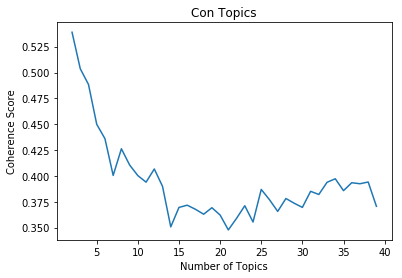

In [20]:
con_x = np.array(con_topics)
con_y = np.array(con_coherence_score)

plt.plot(con_x,con_y)
plt.title('Con Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [21]:
temp_dict = dict(zip(con_topics,con_coherence_score))
temp_dict

{2: 0.53893062540119785,
 3: 0.50364874096531242,
 4: 0.48842352569536562,
 5: 0.44993582801062271,
 6: 0.43601502164674072,
 7: 0.40047295804907945,
 8: 0.42625153775456348,
 9: 0.41055715932589809,
 10: 0.40028972422894682,
 11: 0.39395742023366631,
 12: 0.4067141870735293,
 13: 0.38986811236440377,
 14: 0.35071304776231232,
 15: 0.36953757354631711,
 16: 0.37167720900214235,
 17: 0.36771757564095325,
 18: 0.36295936322683359,
 19: 0.36924297750629947,
 20: 0.36216596682663782,
 21: 0.34777304685523197,
 22: 0.35898732917997783,
 23: 0.37117233868767308,
 24: 0.3554053680520442,
 25: 0.3869223702160462,
 26: 0.37700153393629726,
 27: 0.3656740731069163,
 28: 0.37814588511486552,
 29: 0.3736123270388233,
 30: 0.36954446841339011,
 31: 0.38509712993020812,
 32: 0.38203866274400344,
 33: 0.39382934484855392,
 34: 0.39722912730278637,
 35: 0.38574563087626568,
 36: 0.39339720486677143,
 37: 0.39242941868588788,
 38: 0.39409742902389328,
 39: 0.37061293944312762}

In [22]:
con_topic_output = dict(zip(con_topics, con_model_list))

#getting # of topics = 14
pprint(con_topic_output.get(14).print_topics())

[(0,
  '0.029*"career" + 0.020*"progression" + 0.020*"time" + 0.019*"level" + '
  '0.017*"store" + 0.015*"noise" + 0.015*"extent" + 0.015*"crunch" + '
  '0.015*"e.g." + 0.015*"applicable"'),
 (1,
  '0.035*"management" + 0.017*"senior" + 0.017*"closely" + 0.017*"expand" + '
  '0.016*"stingy" + 0.016*"2nd" + 0.016*"coaster" + 0.016*"roller" + '
  '0.016*"double" + 0.015*"people"'),
 (2,
  '0.027*"customer" + 0.025*"time" + 0.021*"job" + 0.020*"management" + '
  '0.020*"long" + 0.019*"loud" + 0.019*"product" + 0.019*"rude" + '
  '0.017*"system" + 0.016*"employee"'),
 (3,
  '0.042*"schedule" + 0.032*"evening" + 0.032*"formal" + 0.032*"mba" + '
  '0.032*"not" + 0.029*"advancement" + 0.025*"room" + 0.019*"feedback" + '
  '0.016*"hour" + 0.016*"advance"'),
 (4,
  '0.037*"customer" + 0.027*"be" + 0.020*"not" + 0.020*"bonus" + '
  '0.020*"commission" + 0.018*"negative" + 0.017*"bar" + 0.017*"school" + '
  '0.017*"percent" + 0.017*"metric"'),
 (5,
  '0.023*"organize" + 0.023*"be" + 0.023*"produc

Seems like topic start to flat out starting around 15-ish topics in Con Topics

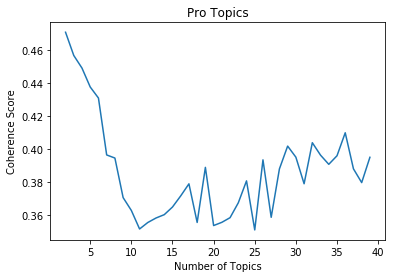

In [23]:
pro_coherence_score, pro_model_list, pro_topics = coherence_scorelist(pro_list, 2,40)

plt.plot(np.array(pro_topics), np.array(pro_coherence_score))
plt.title('Pro Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

Seems like 11 Topics would be better

In [24]:
pro_topic_output = dict(zip(pro_topics, pro_model_list))

pprint(pro_topic_output.get(11).print_topics())

[(0,
  '0.068*"product" + 0.039*"great" + 0.034*"good" + 0.033*"people" + '
  '0.027*"fire" + 0.021*"exciting" + 0.019*"fun" + 0.018*"atmosphere" + '
  '0.018*"price" + 0.017*"spectacular"'),
 (1,
  '0.094*"good" + 0.043*"nice" + 0.039*"discount" + 0.037*"iphone" + '
  '0.023*"environment" + 0.022*"time" + 0.020*"computer" + 0.019*"salary" + '
  '0.018*"company" + 0.018*"free"'),
 (2,
  '0.048*"work" + 0.032*"company" + 0.021*"close" + 0.019*"like" + '
  '0.016*"consumer" + 0.016*"bored" + 0.016*"people" + 0.016*"dynamic" + '
  '0.016*"give" + 0.015*"edge"'),
 (3,
  '0.103*"great" + 0.048*"benefit" + 0.032*"discount" + 0.028*"employee" + '
  '0.027*"profile" + 0.025*"company" + 0.023*"stock" + 0.018*"people" + '
  '0.016*"good" + 0.015*"healthcare"'),
 (4,
  '0.060*"great" + 0.057*"people" + 0.034*"salary" + 0.026*"good" + '
  '0.026*"day" + 0.021*"learn" + 0.020*"retailer" + 0.020*"online" + '
  '0.020*"co_worker" + 0.020*"sell"'),
 (5,
  '0.043*"management" + 0.041*"great" + 0.029*"g